In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import glob
from collections import Counter
import math
import re
import json
import subprocess
import time

import pandas as pd
import umap
from tqdm.autonotebook import tqdm, trange
from nltk.tokenize import word_tokenize

import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.utils import class_weight

from tensorflow import keras

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
#assert gpus
try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
layers = keras.layers
models = keras.models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy.random as rng
from tensorflow.keras import regularizers

import convert_model

import language
import text_nn
import grab_category
import news

In [3]:
folders_train = ["data/sample", "data/sample3", "data/sample4"]
folder_test = "data/sample2"

file_info_train = []
for folder in folders_train:
    file_info_train.extend(language.read_dump(os.path.join(folder, "langs", "dump", "en")))

file_info_test = language.read_dump(os.path.join(folder_test, "langs", "dump", "en"))
print(f"{len(file_info_train)} train examples, {len(file_info_test)} test")

199344 train examples, 36394 test


In [4]:
categories = ["society", "economy", "sports", "science", "other", "technology", "entertainment", "junk"]

def load_cats(folder):
    return {fi.file: cat for cat in categories for fi in language.read_dump(os.path.join(folder, "categories_en", "dump", cat))}
    

cats_train = {}
for folder in folders_train:
    cats_train.update(load_cats(folder))
    
cats_test = load_cats(folder_test)
            
assert len(cats_train) == len(file_info_train)
assert len(cats_test) == len(file_info_test)

def linear_cats(cats, file_info):
    res = ["unknown"] * len(file_info)
    for i, fi in enumerate(file_info):
        res[i] = cats[fi.file]
    
    assert "unknown" not in res
    return res

cats_train = linear_cats(cats_train, file_info_train)
cats_test = linear_cats(cats_test, file_info_test)

In [5]:
file_to_idx = {fi.file: i for i, fi in enumerate(file_info_test)}

manual_ground_truth = {}
gt_junk = 0
gt_cat_mismatch = 0
if os.path.exists(os.path.join(folder_test, "gt_groups_en")):
    with open(os.path.join(folder_test, "gt_groups_en")) as f:
        for line in f:
            idx1, idx2, match = line.strip().split("\t")
            idx1 = file_to_idx[idx1]
            idx2 = file_to_idx[idx2]
            if cats_test[idx1] == "junk" or cats_test[idx2] == "junk":
                gt_junk += 1
                continue
                
            if cats_test[idx1] != cats_test[idx2]:
                gt_cat_mismatch += 1
                continue
                
            match = match == "True"
            manual_ground_truth[(idx1, idx2)] = match
            manual_ground_truth[(idx2, idx1)] = match
            
def get_gt_groups(gt):
    idx_group = {idx1: {idx1} for idx1, _ in gt.keys()}
    not_matching = set()
    for (idx1, idx2), match in gt.items():
        if match:
            if idx_group[idx1] is not idx_group[idx2]:
                idx_group[idx1].update(idx_group[idx2])
                for ii in idx_group[idx2]:
                    idx_group[ii] = idx_group[idx1]
        else:
            not_matching.add((idx1, idx2))
    
    for idx1, idx2 in not_matching:
        assert idx2 not in idx_group[idx1], f"{idx1} and {idx2} are both matching and non-matching in GT. Group: {idx_group[idx1]}"
        
    return idx_group, not_matching
        
print(f"{len(manual_ground_truth) // 2} GT examples loaded: {gt_junk} junk, {gt_cat_mismatch} category mismatches")
gt_groups = get_gt_groups(manual_ground_truth)
print(f"{len(gt_groups[0])} GT groups, {len(gt_groups[1])} non-matching")

0 GT examples loaded: 0 junk, 0 category mismatches
0 GT groups, 0 non-matching


In [6]:
count_input = [f"{len(file_info_train)}"]
for fi in file_info_train:
    count_input.append(" ".join(token for token in news.simple_tokenize_with_numbers(fi.text)))

language.run_process(["groups/Release/news_groups", "count", "data/chunk_counts_en.bin"], "\n".join(count_input) + "\n")

''

In [8]:
def calc_similarities(texts, similarity_cutoff):
    p = subprocess.Popen(["groups/Release/news_groups", "group", "data/chunk_counts_en.bin", str(similarity_cutoff)], stdin=subprocess.PIPE, stdout=subprocess.PIPE,
                         encoding="utf8", text=True)
    
    process_input = f"{len(texts)}\n"
    for text in texts:
        process_input += text + "\n"

    output, _ = p.communicate(process_input)

    similarities = [[y.split(" ") for y in x.strip().split("\t") if y != ""] for x in output[:-1].split("\n")]           
    similarities = [[(int(idx), float(sim)) for idx, sim in sims] for sims in similarities]
    return similarities

def calc_similarities_within_categories(texts, similarity_cutoff, cats):
    all_cats = frozenset(cats) - frozenset(["junk"])
    res = []
    for cat in all_cats:
        idx = [i for i, c in enumerate(cats) if c == cat]
        cat_sims = calc_similarities([texts[i] for i in idx], similarity_cutoff)
        res.extend([[(idx[idx2], sim) for idx2, sim in sims] for sims in cat_sims])
    
    return res

In [9]:
def calc_groups(texts, similarity_cutoff):
    process_input = "\n".join([f"{len(texts)}"] + texts) + "\n"
    output = language.run_process(["groups/Release/news_groups", "group", "data/chunk_counts_en.bin", str(similarity_cutoff)], process_input)
    groups = [[int(y) for y in x.strip().split("\t") if y != ""] for x in output[:-1].split("\n")]           
    return groups

def calc_groups_within_categories(texts, similarity_cutoff, cats):
    all_cats = frozenset(cats) - frozenset(["junk"])
    res = []
    for cat in all_cats:
        idx = [i for i, c in enumerate(cats) if c == cat]
        cat_groups = calc_groups([texts[i] for i in idx], similarity_cutoff)
        res.extend([[idx[i] for i in group] for group in cat_groups])
    
    return res

In [10]:
def idx_group(groups):
    idx_group = {}
    for group in groups:
        for idx in group:
            idx_group[idx] = group
            
    return idx_group

def group_comparison(gt_groups, test_groups):
    gt_idx_group, gt_not_matching = gt_groups
    test_idx_group = idx_group(test_groups)
    true_assignments = []
    test_assignments = []
    for idx1, others in gt_idx_group.items():
        for idx2 in others:
            if idx1 < idx2:
                true_assignments.append(True)                
                test_assignments.append(idx1 in test_idx_group and idx2 in test_idx_group[idx1])
    
    for idx1, idx2 in gt_not_matching:
        true_assignments.append(False)
        test_assignments.append(not (idx1 in test_idx_group and idx2 in test_idx_group[idx1]))
        
    return true_assignments, test_assignments

def group_to_embedding_comparison(gt_groups, embs):
    gt_idx_group, gt_not_matching = gt_groups
    true_assignments = []
    test_assignments = []
    for idx1, others in gt_idx_group.items():
        for idx2 in others:
            if idx1 < idx2:
                true_assignments.append(0)                
                test_assignments.append(((embs[idx1, :] - embs[idx2, :]) ** 2).sum())
    
    for idx1, idx2 in gt_not_matching:
        true_assignments.append(1)
        test_assignments.append(((embs[idx1, :] - embs[idx2, :]) ** 2).sum())
        
    return true_assignments, test_assignments

In [11]:
def calc_groups_within_categories_fi(file_info):    
    texts = [" ".join(token for token in news.simple_tokenize_with_numbers(fi.text)[:500]) for fi in file_info]
    return calc_groups_within_categories(texts, 3.5, cats_test)


#train_groups = calc_groups_within_categories_fi(file_info_train)
test_groups = calc_groups_within_categories_fi(file_info_test)
print(f1_score(*group_comparison(gt_groups, test_groups), average="weighted"))

0


In [12]:
with open("data/grouping_output.txt", "w") as f:
    for group in sorted(test_groups, key=lambda x: len(x), reverse=True):
        f.write(f"GROUP SIZE: {len(group)}\n")
        f.write(f"{cats_test[group[0]]}\n")
        for idx in group:
            f.write(f"{file_info_test[idx].title}\n\t{file_info_test[idx].text[:800]}\n")
            
        f.write("\n\n")

In [82]:
f1_score(*group_comparison(gt_groups, g), average="weighted")

0.25150606036909395

In [96]:
print(len(g))
m = max(len(gg) for gg in g)
print(m)
g.sort(key=lambda gg: len(gg), reverse=True)
gi = 3
print(len(g[gi]))
for idx2 in g[gi]:
    print("\t" + file_info_test[idx2].title)

5474
67
40
	«Разборки двух партий». Экс-глава МИД Украины заявил об отсутствии «Украиногейта» в США и предложил название «Американогейт»
	Тейлор: Джулиани хотел, чтобы Украина вмешалась в американские выборы
	Суд в США обязал обнародовать детали разговора Зеленского и Трампа
	Опрос: Более половины американцев поддерживают импичмент Трампа
	Трамп хотел, чтобы Зеленский сделал заявление о расследовании, Байдене и Клинтон — топ-чиновник Госдепа
	В Белом доме не увидели доказательств quid pro quo в показаниях топ-дипломатов США
	Конгресс опубликовал показания Волкера и Сондленда в деле об импичменте Трампа
	Импичмент Трампа: Болтон не пришел на слушания в Конгресс
	Топ-дипломат США признал связь между военной помощью и расследованием против Байдена
	Более половины американцев поддерживают импичмент Трампа
	В Конгрессе допустили, что расследование по импичменту «зацепит» не только Украину
	«Мистификация демократов». Трамп заявил, что нет причин анализировать его разговор с Зеленским
	Трамп 

In [34]:
texts = [" ".join(token for token in news.simple_tokenize_with_numbers(fi.text)) for fi in file_info_test]
s = camax_group_idximilarities_within_categories(texts, 3.5, cats_test)

In [39]:
with open("data/graph.tsv", "w") as f:
    for idx1, sims in enumerate(s):
        for idx2, sim in sims:
            f.write(f"{idx1}\t{idx2}\t{sim}\n")
            f.write(f"{idx2}\t{idx1}\t{sim}\n")

In [81]:
len([i for i, z in enumerate(s) if len(z) != 0])

23078

In [92]:
relabel = {}
with open("data/relabel") as f:
    for line in f:
        my_lab, other_lab = map(int, line.split(" "))
        relabel[other_lab] = my_lab

last_idx = -1
clusters = {}
with open("data/graph.tree1") as f:
    for line in f:
        idx, cluster = map(int, line.split(" "))
        
        if idx < last_idx:
            break
            
        last_idx = idx
        if cluster not in clusters:
            clusters[cluster] = []
            
        clusters[cluster].append(relabel[idx])
        
for c in list(clusters):
    if len(clusters[c]) == 1:
        del clusters[c]

In [93]:
len(clusters)

630

In [ ]:
c = 1
cc = list(clusters)
for idx2 in clusters[cc[c]]:
    print("\t" + file_info_test[idx2].text)
    

In [69]:
def postprocess_similarities(similarities, cats):
    assert len(similarities) == len(cats), f"{len(similarities)} != {len(cats)}"
    for i in range(len(similarities)):
        if cats[i] == "junk":
            similarities[i] = []           
                        
    similarities = [[[idx2, sim] for idx2, sim in sims if cats[idx2] == cats[idx1]] 
                    for idx1, sims in enumerate(similarities)]
    
    return similarities

def similarity_scores(file_info, cats):
    texts = [" ".join(token for token in news.simple_tokenize_with_numbers(fi.text)) for fi in file_info]
    text_sims = postprocess_similarities(calc_similarities(texts), cats)
    
    titles = [" ".join(token for token in news.simple_tokenize_with_numbers(fi.title)) for fi in file_info]
    title_sims = postprocess_similarities(calc_similarities(titles), cats)
        
    return text_sims, title_sims

text_sims_train, title_sims_train = similarity_scores(file_info_train, cats_train)
text_sims_test, title_sims_test = similarity_scores(file_info_test, cats_test)

In [70]:
def similarities_to_tuples(similarities):
    similarities_tuples = {}
    for idx1, sims in enumerate(similarities):
        for idx2, sim in sims:
            similarities_tuples[(idx1, idx2)] = sim
            similarities_tuples[(idx2, idx1)] = sim
            
    return similarities_tuples
        
def similarities_in_gt(similarities_tuples, gt):
    gt_similarities = {True: [], False: []}
    gt_idx = {True: [], False: []}
    for (idx1, idx2), match in manual_ground_truth.items():
        gt_similarities[match].append(similarities_tuples[(idx1, idx2)] if (idx1, idx2) in similarities_tuples else 0)
        gt_idx[match].append((idx1, idx2))

    sims_joined = np.array(gt_similarities[True] + gt_similarities[False])
    gt_idx_joined = gt_idx[True] + gt_idx[False]
    gt_joined = [1] * len(gt_similarities[True]) + [0] * len(gt_similarities[False])
    return sims_joined, gt_joined, gt_idx_joined


sims_joined, gt_joined, gt_idx_joined = similarities_in_gt(similarities_to_tuples(text_sims_test), manual_ground_truth)
auc = roc_auc_score(gt_joined, sims_joined)
print(f"AUC = {auc}, +{sum(gt_joined)} -{len(gt_joined) - sum(gt_joined)}")

sims_joined_title, _, _ = similarities_in_gt(similarities_to_tuples(title_sims_test), manual_ground_truth)
auc = roc_auc_score(gt_joined, sims_joined_title)
print(f"Title AUC = {auc}, +{sum(gt_joined)} -{len(gt_joined) - sum(gt_joined)}")

auc = roc_auc_score(gt_joined, sims_joined_title + sims_joined)
print(f"Title+text AUC = {auc}, +{sum(gt_joined)} -{len(gt_joined) - sum(gt_joined)}")

AUC = 0.8831964483906771, +510 -1060
Title AUC = 0.6188124306326305, +510 -1060
Title+text AUC = 0.8916944136145024, +510 -1060


In [72]:
def merge_similarities(sim1, sim2, file_info):
    sim1 = similarities_to_tuples(sim1)
    sim2 = similarities_to_tuples(sim2)
    for ff, sim in sim2.items():
        if ff in sim1:
            sim1[ff] += sim
        else:
            sim1[ff] = sim

    merged = [{} for _ in range(len(file_info))]
    for (idx1, idx2), sim in sim1.items():
        merged[idx1][idx2] = sim
        merged[idx2][idx1] = sim
        
    merged = [list(m.items()) for m in merged]    
    return merged
        
similarities_train = merge_similarities(text_sims_train, title_sims_train, file_info_train)
similarities_test = merge_similarities(text_sims_test, title_sims_test, file_info_test)

sims_joined_both, _, _ = similarities_in_gt(similarities_to_tuples(similarities_test), manual_ground_truth)
auc = roc_auc_score(gt_joined, sims_joined_both)
print(f"Title+text AUC = {auc}, +{sum(gt_joined)} -{len(gt_joined) - sum(gt_joined)}")

Title+text AUC = 0.8916944136145024, +510 -1060


(-5, 15)

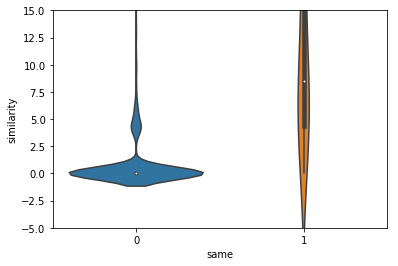

In [77]:
plot_data = pd.DataFrame({"similarity": sims_joined_both, "same": gt_joined, "idx": gt_idx_joined})
#plot_data = plot_data[(plot_data.similarity < 10) & (plot_data.similarity > -3)]
ax = sns.violinplot(x="same", y="similarity", data=plot_data)
ax.set_ylim(-5, 15)

In [10]:
normalizer = news.TextNormalizer("russian")
normalizer.train(file_info_train)
train_texts_train = normalizer.normalize_texts(file_info_train)
train_texts_test = normalizer.normalize_texts(file_info_test)

75760 word stems


In [11]:
verbose = 1
max_words = 7000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_texts_train)  # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_texts_train).astype(np.float32)
x_test = tokenize.texts_to_matrix(train_texts_test).astype(np.float32)

In [71]:
drop_ratio = 0.5
embedding_size = 256


def bag_embedding(input_shape):
    model = models.Sequential()    
    #model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512, input_shape=input_shape, activation='relu', use_bias=False))#, kernel_regularizer=regularizers.l2(0.0001)))
    #model.add(layers.Dropout(drop_ratio))
    model.add(layers.Dense(512, activation='relu', use_bias=False))
    #model.add(layers.Dropout(drop_ratio))
    model.add(layers.Dense(512, activation='relu', use_bias=False))
    #model.add(layers.Dropout(drop_ratio))
    model.add(layers.Dense(embedding_size, use_bias=False, activation="sigmoid"))
    return model


def make_siamese_model(emb_model, input_shape):
    # Define the tensors for the two input images
    left_input = layers.Input(input_shape)
    right_input = layers.Input(input_shape)
        
    # Generate the encodings (feature vectors) for the two images
    encoded_l = emb_model(left_input)
    encoded_r = emb_model(right_input)
    
    #emb_diff = K.square(encoded_l - encoded_r)
    emb_diff = K.abs(encoded_l - encoded_r)
    #emb_diff_drop = layers.Dropout(drop_ratio)(emb_diff)
    distance = K.sum(emb_diff, axis=1, keepdims=True)

    #prediction1 = layers.Dense(64, activation="relu")(emb_diff)
    #prediction = layers.Dense(1, activation="sigmoid")(prediction1)
    prediction = layers.Activation('tanh')(distance)
    #prediction = distance
    
    # Connect the inputs with the outputs
    siamese_net = models.Model(inputs=[left_input, right_input], outputs=prediction)
    
    # return the model
    return siamese_net

emb_model = bag_embedding((max_words,))
model = make_siamese_model(emb_model, (max_words,))
emb_model.summary()
model.summary()

optimizer = Adam(lr = 0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer)
#model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 512)               3584000   
_________________________________________________________________
dense_67 (Dense)             (None, 512)               262144    
_________________________________________________________________
dense_68 (Dense)             (None, 512)               262144    
_________________________________________________________________
dense_69 (Dense)             (None, 256)               131072    
Total params: 4,239,360
Trainable params: 4,239,360
Non-trainable params: 0
_________________________________________________________________
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)    

In [75]:
idx_group_train = idx_group(train_groups)
idx_group_test = idx_group(test_groups)

idx_with_group_train = list(idx_group_train)
idx_with_group_test = list(idx_group_test)


def get_batch(batch_size, is_train):
    """Create batch of n pairs, half same class, half different class"""
    x = x_train if is_train else x_test
    idx_wg = idx_with_group_train if is_train else idx_with_group_test
    idx_g = idx_group_train if is_train else idx_group_test
    
    n_examples = x.shape[0]
   
    # initialize vector for the targets
    targets = np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    num_same = batch_size // 2
    targets[num_same:] = 1
    batch_idx_1 = []
    batch_idx_2 = []
    for i in range(batch_size):
        # pick images of same class for 1st half, different for 2nd
        if i < num_same:
            idx_1 = idx_wg[rng.randint(0, len(idx_wg))]
            ii = rng.randint(0, len(idx_g[idx_1]))
            idx_2 = idx_g[idx_1][ii]
        else: 
            idx_1 = rng.randint(0, n_examples)
            idx_2 = rng.randint(0, n_examples)
            if idx_1 in idx_g:
                group = frozenset(idx_g[idx_1])
                while True:
                    idx_2 = rng.randint(0, n_examples)                    
                    if idx_2 not in group:
                        break
        
        batch_idx_1.append(idx_1)
        batch_idx_2.append(idx_2)
                    
    pairs = [x[batch_idx_1, :], x[batch_idx_2, :]]
    return pairs, targets

def generate(batch_size, is_train):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, is_train)
        yield (pairs, targets)
        
def embedding_distance(embs, idx1, idx2):
    return ((embs[idx1, :] - embs[idx2, :]) ** 2).sum()  

In [76]:
print("Starting training process!")
print("-------------------------------------")
n_iter = 10000
eval_samples = 10000
batch_size = 32
evaluate_every = 1000
t = trange(n_iter)
loss_sum = 0.0
last_eval = 0
val_loss = model.evaluate(*get_batch(eval_samples, False), verbose=0)
best = val_loss
print(f"val loss before training: {val_loss}")
for i in t:
    (inputs,targets) = get_batch(batch_size, True)
    loss = model.train_on_batch(inputs, targets)
    loss_sum += loss
    t.set_description(f"train: {loss_sum / (i - last_eval + 0.01):.2g}\tval: {val_loss:.2g}")
    if i % evaluate_every == 0 and i != 0:
        loss_sum = 0
        last_eval = i
        val_loss = model.evaluate(*get_batch(eval_samples, False), verbose=0)
#        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if best > val_loss:
            embs_test = emb_model.predict(x_test)
            auc = roc_auc_score(*group_to_embedding_comparison(gt_groups, embs_test))
            print(f"Current best loss: {val_loss}, AUC: {auc}")
            best = val_loss

Starting training process!
-------------------------------------


val loss before training: 0.5751081615686416
Current best loss: 0.4362422139644623, AUC: 0.6578202406227884


KeyboardInterrupt: 

In [53]:
emb_model.save('data/keras_model_grouping.h5', include_optimizer=False)
convert_model.convert("data/keras_model_grouping.h5", "data/grouping_model_ru.json", no_tests=False)

tokenizer_data = json.loads(tokenize.to_json())
word_index = json.loads(tokenizer_data["config"]["word_index"])
with open("data/dictionary_for_grouping_ru.tsv", "w") as f:
    for word, index in word_index.items():
        if index < max_words:
            f.write(f"{word}\t{index}\t{normalizer.idf[word] if word in normalizer.idf else 0}\n")

loading data/keras_model_grouping.h5
Forward pass took 0.016979 s.
Forward pass took 0.00348 s.
Forward pass took 0.004065 s.
Starting performance measurements.
Forward pass took 0.003918 s.
Forward pass took 0.00412 s.
Forward pass took 0.003423 s.
Forward pass took 0.003779 s.
Forward pass took 0.004162 s.
Forward pass took 0.0038804 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model hash.
Model conversion finished.
writing data/grouping_model_ru.json


In [49]:
embs_test = emb_model.predict(x_test)

In [50]:
gt_similarities = {True: [], False: []}
for (idx1, idx2), match in manual_ground_truth.items():
    gt_similarities[match].append(-embedding_distance(embs_test, idx1, idx2))

sims_joined_nn = np.array(gt_similarities[True] + gt_similarities[False])
auc = roc_auc_score(gt_joined, sims_joined_nn)
print(f"Emb AUC = {auc}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")

for weight in np.linspace(1, 100, 15):
    auc = roc_auc_score(gt_joined, sims_joined_both + sims_joined_nn * weight)
    print(f"weight={weight} AUC = {auc}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")

for weight in np.linspace(1, 100, 15):
    auc = roc_auc_score(gt_joined, sims_joined_both * weight + sims_joined_nn)
    print(f"weight={weight} AUC = {auc}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")    
    
print()
weight = 5
auc = roc_auc_score(gt_joined, sims_joined_both + sims_joined_nn * weight)
print(f"weight={weight} AUC = {auc}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")

#f1 = f1_score(gt_joined, sims_joined_both + sims_joined_2 * weight)
#print(f"weight={weight} F1 = {f1}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")

Emb AUC = 0.7345837957824639, +510 -1060
weight=1.0 AUC = 0.9189567147613761, +510 -1060
weight=8.071428571428571 AUC = 0.9187643359230485, +510 -1060
weight=15.142857142857142 AUC = 0.9106178320384757, +510 -1060
weight=22.214285714285715 AUC = 0.902286348501665, +510 -1060
weight=29.285714285714285 AUC = 0.8929707732149464, +510 -1060
weight=36.357142857142854 AUC = 0.8843877173510915, +510 -1060
weight=43.42857142857143 AUC = 0.8759378468368479, +510 -1060
weight=50.5 AUC = 0.8678061413244543, +510 -1060
weight=57.57142857142857 AUC = 0.8602589715131336, +510 -1060
weight=64.64285714285714 AUC = 0.8531113577506475, +510 -1060
weight=71.71428571428571 AUC = 0.847036625971143, +510 -1060
weight=78.78571428571428 AUC = 0.8410432852386238, +510 -1060
weight=85.85714285714286 AUC = 0.8358934517203107, +510 -1060
weight=92.92857142857143 AUC = 0.8314613392526822, +510 -1060
weight=100.0 AUC = 0.8272512023677395, +510 -1060
weight=1.0 AUC = 0.9189567147613761, +510 -1060
weight=8.071428571

(-10, 20)

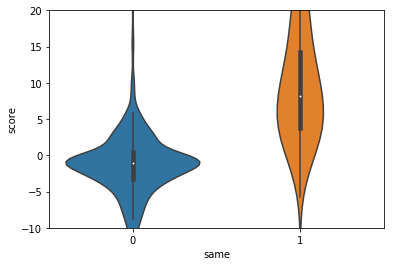

In [51]:
plot_data = pd.DataFrame({"score": sims_joined_both + sims_joined_nn * weight, "same": gt_joined, "idx": gt_idx_joined})
ax = sns.violinplot(x="same", y="score", data=plot_data)
ax.set_ylim(-10, 20)

In [64]:
fitter = umap.UMAP(n_components=5)
embs2_umap = fitter.fit_transform(embs2)

In [65]:
file_to_idx = {fi.file: i for i, fi in enumerate(file_info2)}

gt_similarities = {True: [], False: []}
for (idx1, idx2), match in manual_ground_truth.items():
    gt_similarities[match].append(-((embs2_umap[file_to_idx[idx1], :] - embs2_umap[file_to_idx[idx2]]) ** 2).sum())

sims_joined_3 = np.array(gt_similarities[True] + gt_similarities[False])
auc = roc_auc_score([1] * len(gt_similarities[True]) + [0] * len(gt_similarities[False]), sims_joined_3)
print(f"embs2 UMAP AUC = {auc}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")

auc = roc_auc_score([1] * len(gt_similarities[True]) + [0] * len(gt_similarities[False]), sims_joined)
print(f"similarity AUC = {auc}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")

for weight in np.linspace(1, 100, 15):
    auc = roc_auc_score([1] * len(gt_similarities[True]) + [0] * len(gt_similarities[False]), sims_joined * weight + sims_joined_3)
    print(f"weight={weight} AUC = {auc}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")

embs2 UMAP AUC = 0.732032972520339, +494 -1054
similarity AUC = 0.890469312970062, +494 -1054
weight=1.0 AUC = 0.8990158947214775, +494 -1054
weight=8.071428571428571 AUC = 0.9130514945954875, +494 -1054
weight=15.142857142857142 AUC = 0.9125214144688827, +494 -1054
weight=22.214285714285715 AUC = 0.9119145111355239, +494 -1054
weight=29.285714285714285 AUC = 0.911952922738901, +494 -1054
weight=36.357142857142854 AUC = 0.9116225829498577, +494 -1054
weight=43.42857142857143 AUC = 0.9115611243844541, +494 -1054
weight=50.5 AUC = 0.9115918536671559, +494 -1054
weight=57.57142857142857 AUC = 0.9115764890258049, +494 -1054
weight=64.64285714285714 AUC = 0.9115688067051295, +494 -1054
weight=71.71428571428571 AUC = 0.911507348139726, +494 -1054
weight=78.78571428571428 AUC = 0.9114766188570244, +494 -1054
weight=85.85714285714286 AUC = 0.9114919834983752, +494 -1054
weight=92.92857142857143 AUC = 0.9114612542156735, +494 -1054
weight=100.0 AUC = 0.9114228426122964, +494 -1054


In [47]:
category_coefs_test = news.run_nn(file_info_test, "russian", news.category_model_ru, news.dictionary_ru)
category_coefs_test = np.array(category_coefs_test)

In [50]:
gt_similarities = {True: [], False: []}
for (idx1, idx2), match in manual_ground_truth.items():
    gt_similarities[match].append(-embedding_distance(category_coefs_test, idx1, idx2))

sims_joined_catnn = np.array(gt_similarities[True] + gt_similarities[False])
auc = roc_auc_score(gt_joined, sims_joined_catnn)
print(f"cat-emb AUC = {auc}, +{len(gt_similarities[True])} -{len(gt_similarities[False])}")


cat-emb AUC = 0.4928375878653348, +510 -1060


In [73]:
with open("data/manual_grouping.txt", "w") as f:
    for idx1 in np.random.choice(len(similarities2), 1000):
        cat = cats2[file_info2[idx1].file]
        if cat == "junk":
            continue
            
        f.write(f"\n\n\nFILE#{idx1}\n{cat}\n{file_info2[idx1].text}\n")
        sims = similarities2[idx1]
        sims_adjusted = [(idx2, sim - 5 * embedding_distance(embs2, idx1, idx2)) for idx2, sim in sims]
        sims_adjusted.sort(key=lambda x: x[1], reverse=True)
        for idx2, similarity in sims_adjusted:
            assignment = ""
            if (file_info2[idx1].file, file_info2[idx2].file) in manual_ground_truth:
                assignment = "+" if manual_ground_truth[file_info2[idx1].file, file_info2[idx2].file] else "-"
                
            cat2 = cats2[file_info2[idx2].file]
            f.write(f"\nSimilarity = {similarity}\n{cat2}\n\t{file_info2[idx2].text[:800]}\nOTHER#{idx2}:\n")

In [32]:
manual_ground_truth = {}
if os.path.exists(os.path.join(folder2, "gt_groups")):
    with open(os.path.join(folder2, "gt_groups")) as f:
        for line in f:
            idx1, idx2, match = line.strip().split("\t")
            match = match == "True"
            manual_ground_truth[(idx1, idx2)] = match
            manual_ground_truth[(idx2, idx1)] = match
        
print(len(manual_ground_truth) // 2, "GT examples loaded")

with open("data/manual_grouping.txt") as f:
    idx1 = None
    for line in f:
        if line.startswith("FILE#"):
            idx1 = file_info2[int(line.split("#")[1].strip())].file
        elif line.startswith("OTHER#"):
            idx2 = file_info2[int(line.split("#")[1].split(":")[0])].file
            mark = line.split(":")[1].strip()
            if mark == "":
                continue
            
            match = mark[0] != "-"
            manual_ground_truth[(idx1, idx2)] = match
            manual_ground_truth[(idx2, idx1)] = match
    
print(len(manual_ground_truth) // 2, "examples now in GT")

with open(os.path.join(folder2, "gt_groups"), "w") as f:
    for (idx1, idx2), match in manual_ground_truth.items():
        f.write(f"{idx1}\t{idx2}\t{match}\n")

877 GT examples loaded
1053 examples now in GT
